In [1]:
import numpy as np
import wandb

import shutil

import torch
import scipy
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate
import tqdm

import itertools

from matplotlib import rc

rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})

%matplotlib inline
palette = sns.color_palette()

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


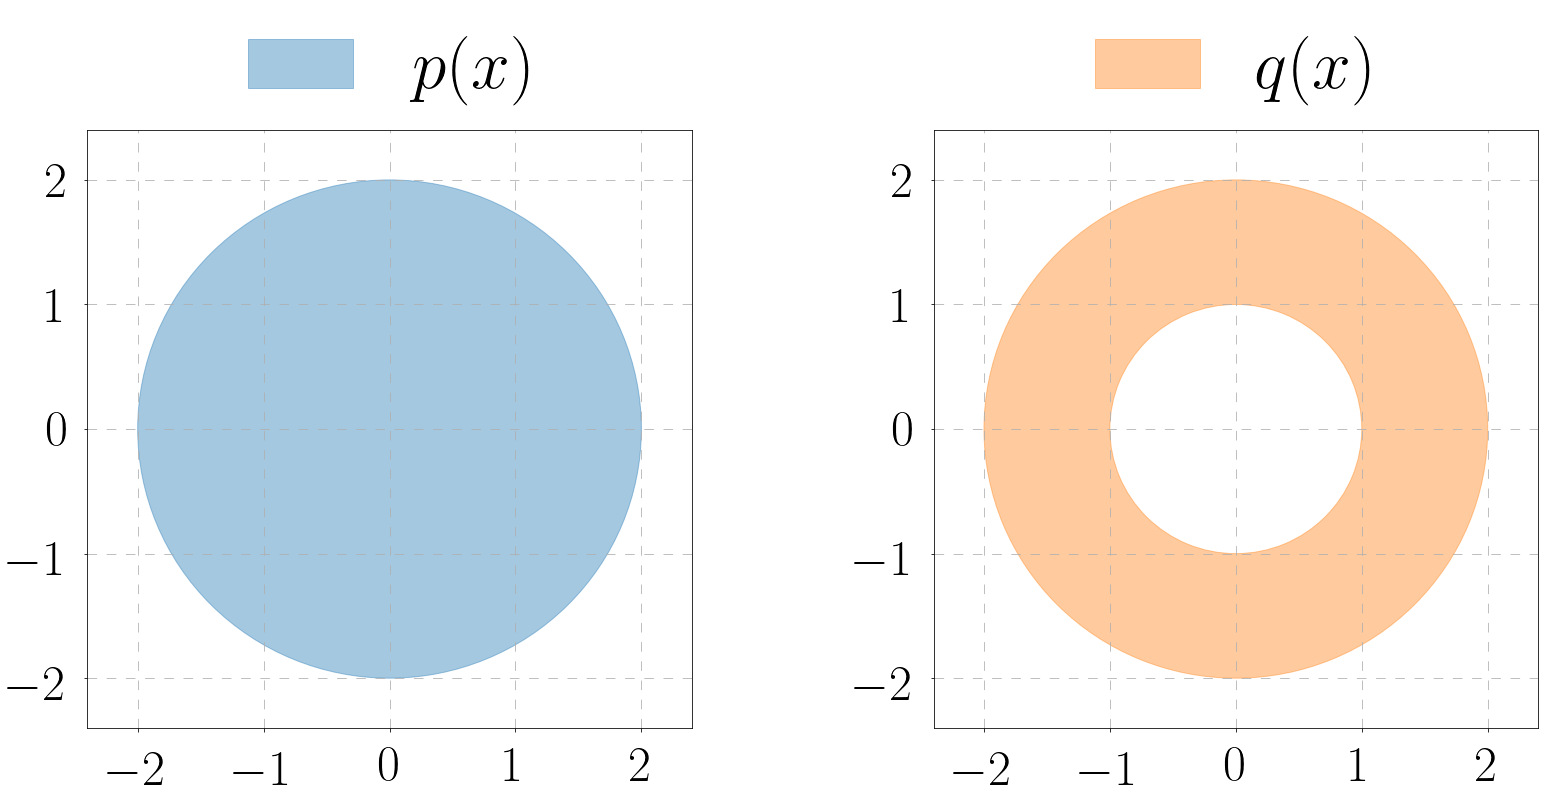

In [2]:
import matplotlib.patches as mpatches

pallete = sns.color_palette()

fig, axes = plt.subplots(figsize=(26, 11), nrows=1, ncols=2)#, sharey='all')
plt.sca(axes[1])

plt.xlabel('')
plt.ylabel('')

ring = mpatches.Wedge((0.0, 0.0), 2.0, 0, 360, width=1.0, color=palette[1], alpha=0.4, figure=fig)
c_patch = mpatches.Patch(color=palette[1], alpha=0.4, label='$q(x)$')
plt.legend(handles=[c_patch], fontsize=70, bbox_to_anchor=(0.5, 1.1), loc='center',
           frameon=False, handlelength=1.5)
plt.gca().add_patch(ring)

plt.xlim([-2.4, 2.4])
plt.ylim([-2.4, 2.4])


plt.gca().tick_params(axis='both', which='major', pad=15)
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
plt.grid(linestyle='--', dashes=(12, 12))


plt.sca(axes[0])

plt.xlabel('')
plt.ylabel('')

ball = mpatches.Circle((0.0, 0.0), 2.0, color=palette[0], alpha=0.4, figure=fig)

c_patch = mpatches.Patch(color=palette[0], alpha=0.4, label='$p(x)$')
plt.legend(handles=[c_patch], fontsize=70, bbox_to_anchor=(0.5, 1.1), loc='center',
           frameon=False, handlelength=1.5)
plt.gca().add_patch(ball)

plt.xlim([-2.4, 2.4])
plt.ylim([-2.4, 2.4])


plt.gca().tick_params(axis='both', which='major', pad=15)
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
plt.grid(linestyle='--', dashes=(12, 12))

plt.subplots_adjust(wspace=0.4)

plt.savefig('./figures/support_slice.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [3]:
class DensityP(object):
    def __init__(self):
        self.weights = np.array([40, 30, 30]).astype(np.float64)
        self.weights /= np.sum(self.weights)
        self.locs = np.array([-1.3, -0.3, 1.5])
        self.scales = np.array([0.5, 1.2, 0.9])
        
        self.left_clips = (-2.0 - self.locs) / self.scales
        self.right_clips = (2 - self.locs) / self.scales
        
    def __call__(self, x):
        if isinstance(x, float):
            x = np.array([x])
        comp_pdf = scipy.stats.truncnorm.pdf(x[:, None], 
                                             self.left_clips[None, :], self.right_clips[None, :], 
                                             loc=self.locs[None, :], scale=self.scales[None, :])        
        pdf = np.sum(self.weights[None, :] * comp_pdf, axis=1)        
        return pdf
        
    
density_p = DensityP()

class DensityQ(object):
    def __init__(self):
        self.weights = np.array([60, 15, 10, 15]).astype(np.float64)
        self.weights /= np.sum(self.weights)
        self.locs = np.array([0.2, -0.7, 1.2, -1.8])
        self.scales = np.array([0.7, 3.5, 2.0, 1.2])
        
        self.left_clips = (-2.0 - self.locs) / self.scales
        self.right_clips = (2 - self.locs) / self.scales
        
    def __call__(self, x):
        if isinstance(x, float):
            x = np.array([x])
        comp_pdf = scipy.stats.truncnorm.pdf(x[:, None], 
                                             self.left_clips[None, :], self.right_clips[None, :], 
                                             loc=self.locs[None, :], scale=self.scales[None, :])        
        pdf = np.sum(self.weights[None, :] * comp_pdf, axis=1)        
        return pdf
        
    
density_q = DensityQ()



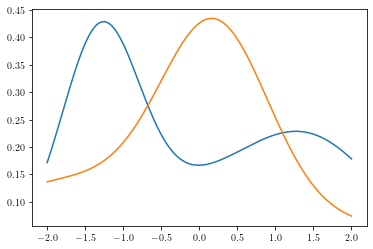

In [4]:
x_grid = np.linspace(-2.0, 2.0, 250)
plt.plot(x_grid, density_p(x_grid))
plt.plot(x_grid, density_q(x_grid))
plt.show()

In [5]:
print(scipy.integrate.quad(density_p, -2.0, 2.0))
print(scipy.integrate.quad(density_q, -2.0, 2.0))

(1.0, 5.838586938141516e-12)
(1.0000000000000002, 1.1102230246251565e-14)


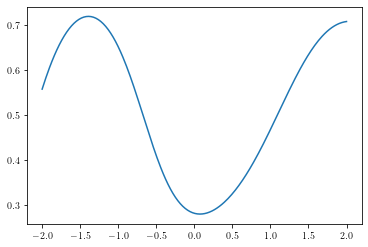

0.2793951896040762 0.7185922189571127
0.556960255233064 0.7071844699289485


In [6]:
f_val = density_p(x_grid) / (density_p(x_grid) + density_q(x_grid))
plt.plot(x_grid, f_val)
plt.show()

print(np.min(f_val), np.max(f_val))
print(f_val[0], f_val[-1])

In [7]:
int_x_grid = np.linspace(-2.0, 2.0, 15000)
f_grid = np.linspace(0.0, 1.0, 150)

def f(x):
    return density_p(x) / (density_p(x) + density_q(x))

c_pf_p = []
c_pf_q = []

for f_value in tqdm.notebook.tqdm(f_grid):
    
    def indicator_f_p(x):
        ind = np.less_equal(f(x), f_value).astype(np.float64)
        return ind * density_p(x)
    
    def indicator_f_q(x):
        ind = np.less_equal(f(x), f_value).astype(np.float64)
        return ind * density_q(x)
    
    y_ind_f_p = indicator_f_p(int_x_grid)
    c_pf_p.append(np.trapz(y_ind_f_p, int_x_grid))
    y_ind_f_q = indicator_f_q(int_x_grid)
    c_pf_q.append(np.trapz(y_ind_f_q, int_x_grid))

c_pf_p = np.array(c_pf_p)
c_pf_q = np.array(c_pf_q)


d_pf_p = np.diff(c_pf_p) / (f_grid[1] - f_grid[0])
d_pf_q = np.diff(c_pf_q) / (f_grid[1] - f_grid[0])

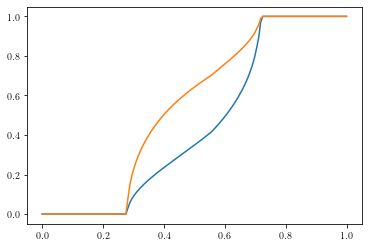

In [8]:
plt.plot(f_grid, c_pf_p)
plt.plot(f_grid, c_pf_q)
plt.show()

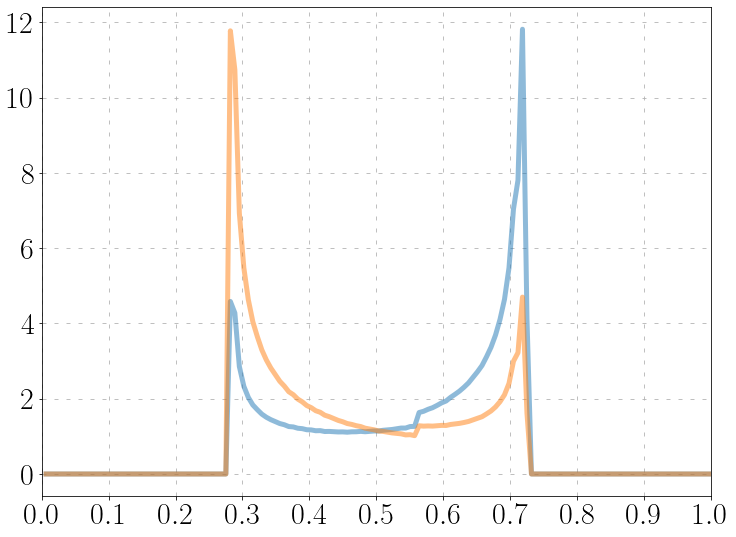

In [9]:
from scipy.ndimage import gaussian_filter1d

sigma = 1.2
d_pf_p_smooth = scipy.ndimage.gaussian_filter1d(d_pf_p, sigma=sigma)
d_pf_q_smooth = scipy.ndimage.gaussian_filter1d(d_pf_q, sigma=sigma)

f_min = np.min(f_val)
f_max = np.max(f_val)

fig = plt.figure(figsize=(12, 9))

plt.grid(linestyle='--', dashes=(5, 10))

plt.plot(f_grid[1:], d_pf_p, c=palette[0], linewidth=5, alpha=0.5)
plt.plot(f_grid[1:], d_pf_q, c=palette[1], linewidth=5, alpha=0.5)
plt.xlim([0.0, 1.0])

plt.xticks(np.linspace(0.0, 1.0, 11), fontsize=30)
plt.yticks(fontsize=30)


plt.show()

In [10]:
x_1 = -1.0
x_2 = 1.57

px_1, px_2 = np.interp([x_1, x_2], x_grid, density_p(x_grid))
qx_1, qx_2 = np.interp([x_1, x_2], x_grid, density_q(x_grid))
fx_1 = px_1 / (px_1 + qx_1)
fx_2 = px_2 / (px_2 + qx_2)
fx_avg = 0.5 * (fx_1 + fx_2)

d_pf_p_a = np.interp(fx_avg, f_grid[1:], d_pf_p)
d_pf_q_a = np.interp(fx_avg, f_grid[1:], d_pf_q)

d_pf_p_smooth_a = np.interp(fx_avg, f_grid[1:], d_pf_p_smooth)
d_pf_q_smooth_a = np.interp(fx_avg, f_grid[1:], d_pf_q_smooth)

print(px_1, qx_1, fx_1)
print(px_2, qx_2, fx_2)
print(d_pf_p_a, d_pf_q_a, d_pf_p_a / (d_pf_p_a + d_pf_q_a))
print(d_pf_p_smooth_a, d_pf_q_smooth_a, d_pf_p_smooth_a / (d_pf_p_smooth_a + d_pf_q_smooth_a))

0.38803070506465387 0.20802174643368831 0.65100093807052
0.21966994896500316 0.11766425708777499 0.6511938161724232
2.7192906562611814 1.4784963801512865 0.6477914750494713
2.7359692856973408 1.4843740028215837 0.6482812175825381


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


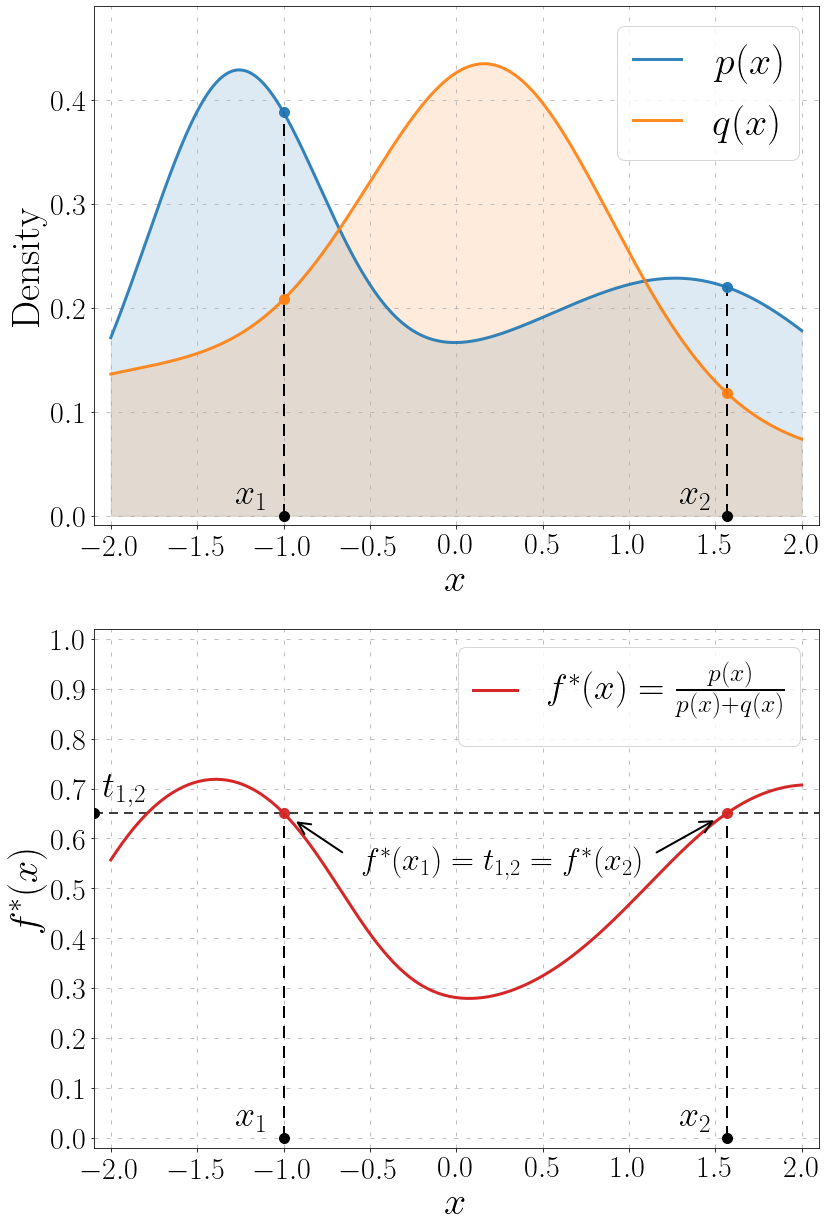

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(13, 21))

plt.sca(axes[0])

plt.grid(linestyle='--', dashes=(5, 10))

plt.plot(x_grid, density_p(x_grid), c=palette[0], linewidth=3, alpha=0.9, label='$p(x)$')
plt.plot(x_grid, density_q(x_grid), c=palette[1], linewidth=3, alpha=0.9, label='$q(x)$')

plt.fill_between(x_grid, 0, density_p(x_grid), color=palette[0], alpha=0.15)
plt.fill_between(x_grid, 0, density_q(x_grid), color=palette[1], alpha=0.15)
plt.plot([x_1, x_1], [0.0, px_1], c='k', linewidth=2, ls=(0, (6, 4)))
plt.plot([x_2, x_2], [0.0, px_2], c='k', linewidth=2, ls=(0, (6, 4)))
plt.plot([x_1], [0.0], marker='o', c='k', markersize=10)
plt.plot([x_1], [px_1], marker='o', c=palette[0], markersize=10, alpha=0.95)
plt.plot([x_1], [qx_1], marker='o', c=palette[1], markersize=10, alpha=0.95)
plt.plot([x_2], [0.0], marker='o', c='k', markersize=10)
plt.plot([x_2], [px_2], marker='o', c=palette[0], markersize=10, alpha=0.95)
plt.plot([x_2], [qx_2], marker='o', c=palette[1], markersize=10, alpha=0.95)

plt.annotate('$x_1$', fontsize=36, xy=(x_1, 0.0),  xycoords='data', xytext=(x_1 - 0.09, 0.00),
             horizontalalignment='right', verticalalignment='bottom')
plt.annotate('$x_2$', fontsize=36, xy=(x_2, 0.0),  xycoords='data', xytext=(x_2 - 0.09, 0.00),
             horizontalalignment='right', verticalalignment='bottom')

plt.legend(fontsize=40, handlelength=1.2)
plt.xlabel('$x$', fontsize=40)
plt.ylabel('Density', fontsize=40)
plt.xlim([-2.1, 2.1])
plt.ylim([-0.009, 0.49])
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.sca(axes[1])

plt.grid(linestyle='--', dashes=(5, 10))

plt.axhline(fx_avg, c='k', ls=(0, (6, 4)))
plt.plot([x_1, x_1], [0.0, fx_1], c='k', linewidth=2, ls=(0, (6, 4)))
plt.plot([x_2, x_2], [0.0, fx_2], c='k', linewidth=2, ls=(0, (6, 4)))
plt.plot([x_1], [0.0], marker='o', c='k', markersize=10)
plt.plot([x_1], [fx_1], marker='o', c=palette[3], markersize=10, alpha=0.95)
plt.plot([x_2], [0.0], marker='o', c='k', markersize=10)
plt.plot([x_2], [fx_2], marker='o', c=palette[3], markersize=10, alpha=0.95)
plt.plot([-2.1], [fx_avg], marker='o', c='k', markersize=10)

plt.plot(x_grid, f_val, c=palette[3], linewidth=3, label='$f^*(x) = \\frac{p(x)}{p(x) + q(x)}$')


plt.annotate('$x_1$', fontsize=36, xy=(x_1, 0.0),  xycoords='data', xytext=(x_1 - 0.09, 0.00),
             horizontalalignment='right', verticalalignment='bottom')
plt.annotate('$x_2$', fontsize=36, xy=(x_2, 0.0),  xycoords='data', xytext=(x_2 - 0.09, 0.00),
             horizontalalignment='right', verticalalignment='bottom')

plt.annotate('$t_{1,2}$', fontsize=36, xy=(-2.0, fx_avg),  xycoords='data', xytext=(-2.05, fx_avg + 0.01),
             horizontalalignment='left', verticalalignment='bottom')

plt.annotate('$f^*(x_1) = t_{1,2} = f^*(x_2)$', fontsize=32, xy=(0.27, fx_avg),  xycoords='data', xytext=(0.27, fx_avg - 0.07),
             horizontalalignment='center', verticalalignment='top')

plt.annotate('', xy=(x_1, fx_1), xycoords='data',
             xytext=(-0.65, 0.57), textcoords='data',
             arrowprops=dict(arrowstyle='->', facecolor='black', shrinkB=15, lw=2, mutation_scale=30),
             horizontalalignment='right', verticalalignment='top')

plt.annotate('', xy=(x_2, fx_2), xycoords='data',
             xytext=(1.15, 0.57), textcoords='data',
             arrowprops=dict(arrowstyle='->', facecolor='black', shrinkB=15, lw=2, mutation_scale=30),
             horizontalalignment='right', verticalalignment='top')

plt.xlim([-2.1, 2.1])
plt.ylim([-0.02, 1.02])
plt.legend(fontsize=37, handlelength=1.2, handleheight=2.2)
plt.xlabel('$x$', fontsize=40)
plt.ylabel('$f^*(x)$', fontsize=40)
plt.xticks(fontsize=30)
plt.yticks(np.linspace(0.0, 1.0, 11), fontsize=30)

plt.savefig('./figures/pushforward_part_1.pdf', format='pdf', bbox_inches='tight')

plt.show()

In [12]:
np.where(np.abs(f_val - 0.636) <= 3e-3)[0]

array([ 11,  65, 218, 219])

In [13]:
x_grid[[9, 30, 218, 240]]

array([-1.85542169, -1.51807229,  1.50200803,  1.85542169])

In [14]:
f(-1.0), f(1.5)

(array([0.65101896]), array([0.63347652]))

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


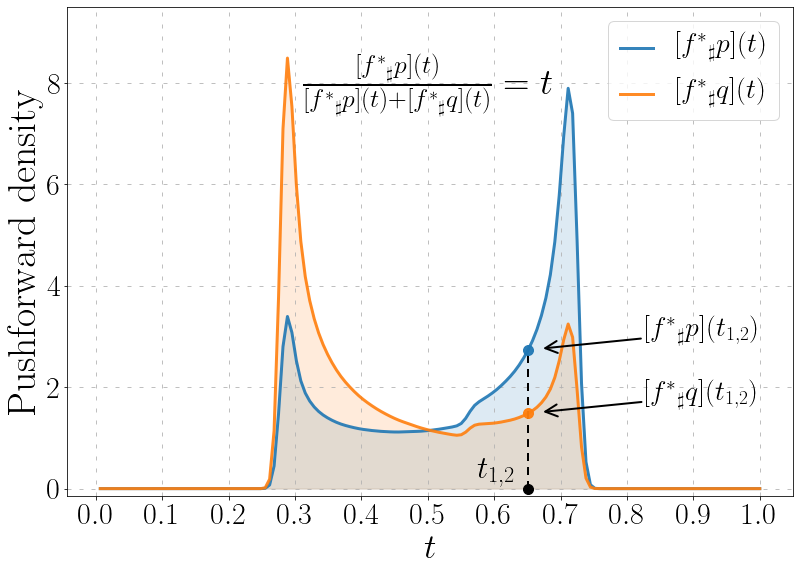

In [15]:
from scipy.ndimage import gaussian_filter1d

f_min = np.min(f_val)
f_max = np.max(f_val)

sigma = 1.2


delta = -0.04
range_mask = np.logical_and(f_grid[1:] >= f_min + delta, f_grid[1:] <= f_max - delta)

def filter_in_range(x, mask):    
    x = x.copy()
    x_range = x[mask]
    x[mask] = scipy.ndimage.gaussian_filter1d(x_range, sigma=sigma)
    return x

d_pf_p_filt = filter_in_range(d_pf_p, range_mask)
d_pf_q_filt = filter_in_range(d_pf_q, range_mask)


fig = plt.figure(figsize=(13, 9))

plt.grid(linestyle='--', dashes=(5, 10))

plt.plot(f_grid[1:], d_pf_p_filt, c=palette[0], linewidth=3, alpha=0.9, label='$[{f^*}_\\sharp p](t)$')
plt.plot(f_grid[1:], d_pf_q_filt, c=palette[1], linewidth=3, alpha=0.9, label='$[{f^*}_\\sharp q](t)$')
plt.fill_between(f_grid[1:], 0, d_pf_p_filt, color=palette[0], alpha=0.15)
plt.fill_between(f_grid[1:], 0, d_pf_q_filt, color=palette[1], alpha=0.15)
plt.plot([fx_avg, fx_avg], [0.0, d_pf_p_smooth_a], c='k', linewidth=2, ls=(0, (4, 3)))
plt.plot([fx_avg], [0.0], marker='o', color='k', markersize=10)
plt.plot([fx_avg], [d_pf_p_smooth_a], marker='o', color=palette[0], markersize=10, alpha=0.95)
plt.plot([fx_avg], [d_pf_q_smooth_a], marker='o', color=palette[1], markersize=10, alpha=0.95)

plt.annotate('$t_{1,2}$', fontsize=32, xy=(fx_avg, 0.0),  xycoords='data', xytext=(fx_avg - 0.02, 0.00),
             horizontalalignment='right', verticalalignment='bottom')
plt.annotate('$\\frac{[{f^*}_\\sharp p](t)}{[{f^*}_\\sharp p](t) + [{f^*}_\\sharp q](t)} = t$', fontsize=37, xy=(0.5, 5.5),  xycoords='data', xytext=(0.5, 8.5),
             horizontalalignment='center', verticalalignment='top')

plt.annotate('$[{f^*}_\\sharp p](t_{1, 2})$', fontsize=28, xy=(fx_avg, d_pf_p_smooth_a),  
             xycoords='data', xytext=(fx_avg + 0.35, d_pf_p_smooth_a + 0.04),
             horizontalalignment='right', verticalalignment='bottom',
             arrowprops=dict(arrowstyle='->', facecolor='black', shrinkB=15, lw=2, mutation_scale=30))

plt.annotate('$[{f^*}_\\sharp q](t_{1,2})$', fontsize=28, xy=(fx_avg, d_pf_q_smooth_a),  
             xycoords='data', xytext=(fx_avg + 0.35, d_pf_q_smooth_a + 0.04),
             horizontalalignment='right', verticalalignment='bottom',
             arrowprops=dict(arrowstyle='->', facecolor='black', shrinkB=15, lw=2, mutation_scale=30))

plt.legend(fontsize=28, handlelength=1.2)

plt.xlabel('$t$', fontsize=35)
plt.ylabel('Pushforward density', fontsize=40)


plt.ylim([-0.15, 9.5])
plt.xticks(np.linspace(0.0, 1.0, 11), fontsize=30)
plt.yticks(fontsize=30)

plt.savefig('./figures/pushforward_part_2.pdf', format='pdf', bbox_inches='tight')

plt.show()